In [1]:
import pickle

with open('user_comments_with_sentiment.pickle', 'rb') as read_file:
    data_raw = pickle.load(read_file)

In [3]:
data_raw.shape

(7283, 22)

In [8]:
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import os
from dotenv import load_dotenv
load_dotenv()


True

In [9]:
IBM_API_KEY = os.environ['IBM_API_KEY']

authenticator = IAMAuthenticator(IBM_API_KEY)
tone_analyzer = ToneAnalyzerV3(
    version='2020-02-25',
    authenticator=authenticator
)

tone_analyzer.set_service_url('https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/421d8d20-ab81-4291-a7ba-0e37f6cbf9de')

In [12]:
resp = tone_analyzer.tone(
            {'text': ' '.join(data_raw.text[4])},
            content_type='application/json',
            sentences=True
        )

In [88]:
import time

def comments_to_text(comments):
    size = np.min([50, len(comments)])
    comments_to_tone = np.random.choice(comments, size=size, replace=False)
    comment_to_tone = [x[0:100] for x in comments_to_tone]
    return ' '.join(comments)

def get_tone(comments):
#     time.sleep(0.2)
    try:
        tone_text = comments_to_text(comments)
        resp = tone_analyzer.tone(
            {'text': tone_text},
            content_type='application/json',
            sentences=True
        )
        if resp.status_code == 200:
            return resp.result
        else:
            return {'error': resp.status_code}
    except Exception as e:
        return {'error': e}
    


In [35]:
first_50 = data_raw.iloc[0:50, :].text.map(get_tone)

In [89]:
tone_1000 = data_raw.iloc[:100, :].text.map(get_tone)

ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Input text exceeded API limit of 131,072 bytes, Code: 400 , X-global-transaction-id: 40103192c8501376c50d58300639f8c0
ERROR:root:Request Entity Too Large
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: Request Entity Too Large, Code: 413
ERROR:root:Input text exceeded API limit of 131,072 bytes
Traceback (most recent call last):
  File "/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ibm_

In [90]:
tone_1000

4      {'document_tone': {'tones': [{'score': 0.60518...
6      {'document_tone': {'tones': [{'score': 0.52230...
11     {'document_tone': {'tones': [{'score': 0.55699...
17     {'document_tone': {'tones': [{'score': 0.50914...
19     {'document_tone': {'tones': [{'score': 0.54253...
                             ...                        
298    {'document_tone': {'tones': [{'score': 0.57562...
300    {'document_tone': {'tones': [{'score': 0.51884...
301    {'document_tone': {'tones': [{'score': 0.71575...
302    {'document_tone': {'tones': [{'score': 0.61613...
303    {'document_tone': {'tones': [{'score': 0.54574...
Name: text, Length: 100, dtype: object

In [57]:
sample_text_sentiment = [0.0,
 0.8346,
 0.2551,
 0.7149,
 0.0,
 0.4404,
 0.575,
 0.0,
 0.5719,
 0.0,
 0.0,
 -0.3147,
 0.0,
 0.7424,
 0.4215,
 -0.2732,
 0.6588,
 0.0,
 0.3612,
 -0.6124,
 0.0107,
 0.0,
 0.0,
 0.8964,
 -0.974,
 -0.212,
 0.0]

In [60]:
def bucket_sentiment(sentiments):
    results = [0, 0, 0]
    for s in sentiments:
        if s <= -0.05:
            results[0] += 1
        elif s < 0.05:
            results[1] += 1
        else:
            results[2] += 1
    return tuple(results)

In [68]:
def process_raw_sentiment_scores(df):
    df['sent_tuples'] = df.text_sentiment.map(bucket_sentiment)
    df['num_neg_sent_comments'] = df.sent_tuples.map(lambda x: x[0])
    df['num_neu_sent_comments'] = df.sent_tuples.map(lambda x: x[1])
    df['num_pos_sent_comments'] = df.sent_tuples.map(lambda x: x[2])
    df['perc_neg_sent_comments'] = df['num_neg_sent_comments'] / (df['num_neg_sent_comments'] + df['num_neu_sent_comments'] + df['num_pos_sent_comments'])
    df['perc_neu_sent_comments'] = df['num_neu_sent_comments'] / (df['num_neg_sent_comments'] + df['num_neu_sent_comments'] + df['num_pos_sent_comments'])
    df['perc_pos_sent_comments'] = df['num_pos_sent_comments'] / (df['num_neg_sent_comments'] + df['num_neu_sent_comments'] + df['num_pos_sent_comments'])
    return df.drop('sent_tuples', axis=1)

In [69]:
data_processed = process_raw_sentiment_scores(data_raw)

In [71]:
def process_raw_subreddit_counts(df):
    for col in [
        'num_comments_political_discussion',
         'num_comments_democrats',
         'num_comments_warren',
         'num_comments_pete',
         'num_comments_biden',
         'num_comments_sanders',
         'num_comments_bloomberg',
         'num_comments_klob'
    ]:
        df[col.replace('num', 'perc')] = df[col] / df['num_comments']
    return df

In [72]:
data_processed = process_raw_subreddit_counts(data_processed)

In [73]:
data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7283 entries, 4 to 21961
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   num_comments                        7283 non-null   int64  
 1   total_comment_length                7283 non-null   int64  
 2   text                                7283 non-null   object 
 3   total_comment_score                 7283 non-null   int64  
 4   best_comment_score                  7283 non-null   int64  
 5   worst_comment_score                 7283 non-null   int64  
 6   number_neg_score_comments           7283 non-null   int64  
 7   number_pos_score_comments           7283 non-null   int64  
 8   total_neg_score                     7283 non-null   int64  
 9   total_pos_score                     7283 non-null   int64  
 10  num_comments_politics               7283 non-null   int64  
 11  num_comments_political_discussion   7283 n

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

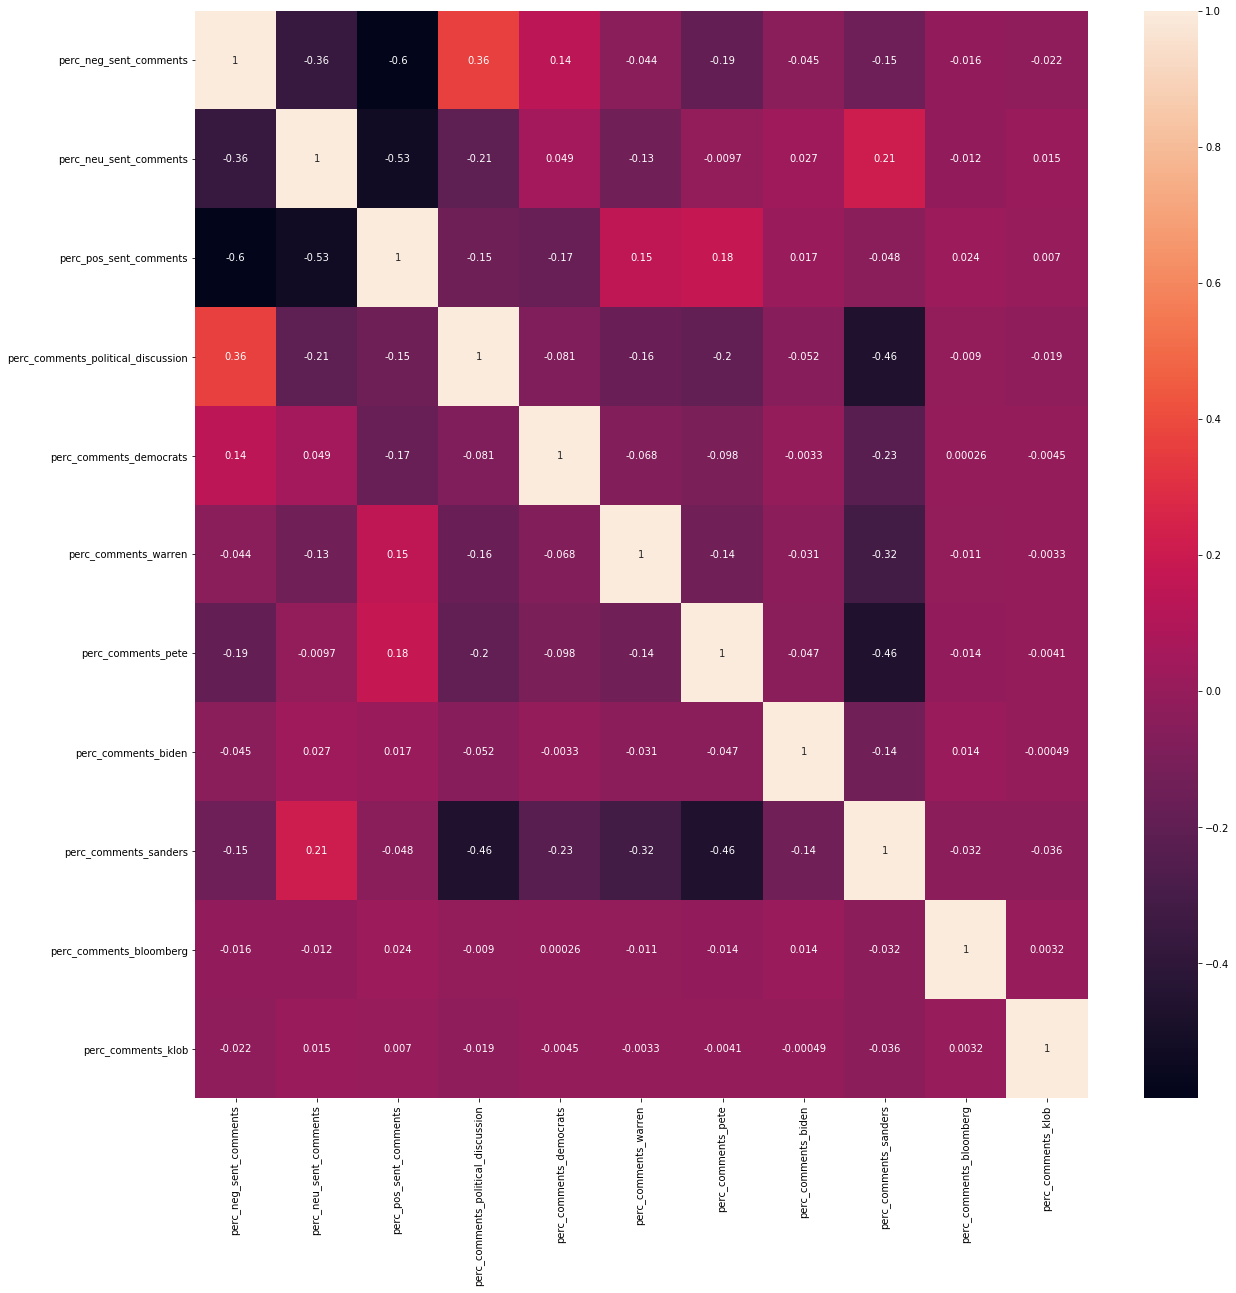

In [80]:
plt.figure(figsize=(20, 20))
sns.heatmap(data_processed.iloc[:, 25:].corr(), annot=True)